# TF-IA: Reconocimiento Facial

## Vinculación con Google Drive

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerías

In [49]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## Direcciones 

In [50]:
direccion = '/content/drive/MyDrive/' + 'TF_IA/'
dir_conocidos = direccion + 'knowns'
dir_no_conocidos = direccion + 'unknowns'
dir_resultados = direccion + 'results'

## Detección Facial

In [51]:
# Leer modelo de detección faciales -> MobileNet

with tf.io.gfile.GFile(direccion + 'modelo_deteccion_facial.pb', 'rb') as f:
  graph_def = tf.compat.v1.GraphDef()
  graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as modelo_deteccion:
  tf.import_graph_def(graph_def, name='')

In [52]:
print(modelo_deteccion)

In [53]:
# Cargar imagenes

def load_image(dir, nombre):
  return cv2.cvtColor(cv2.imread(f'{dir}/{nombre}'), cv2.COLOR_BGR2RGB)

In [54]:
def detect_faces(imagen, score_threshold = 0.7):
  global cuadros, scores
  (imh, imw) = imagen.shape[:-1]
  img = np.expand_dims(imagen, axis = 0)

  # Iniciar modelo de deteccion facial
  sesion = tf.compat.v1.Session(graph=modelo_deteccion)
  imagen_tensor = modelo_deteccion.get_tensor_by_name('image_tensor:0')
  cuadros = modelo_deteccion.get_tensor_by_name('detection_boxes:0')
  scores = modelo_deteccion.get_tensor_by_name('detection_scores:0')

  # Predicción
  (cuadros, scores) = sesion.run([cuadros, scores], feed_dict = {imagen_tensor:img})

  # Ajustar tamaños
  cuadros = np.squeeze(cuadros, axis = 0)
  scores = np.squeeze(scores, axis = 0)

  # Depurar cuadros delimitadores
  idx = np.where(scores >= score_threshold)[0]

  # Crear cuadros delimitadores

  cuadros_d = []
  for index in idx:
    ymin, xmin, ymax, xmax = cuadros[index,:]
    (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    cuadros_d.append([left, right, top, bottom])
  
  return cuadros_d

In [55]:
# Dibujar cuadros delimitadores

def draw_box(imagen, cuadro, color, ancho_borde = 6):
  if cuadro == []:
    return imagen
  else:
    cv2.rectangle(imagen, (cuadro[0], cuadro[2]), (cuadro[1], cuadro[3]), color, ancho_borde)
  return imagen

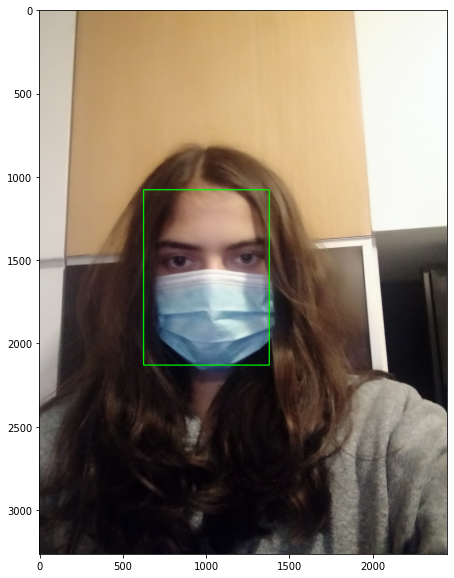

In [56]:
nombre = 'Natalia04.jpg'
imagen = load_image(dir_no_conocidos, nombre)
cuadros_d = detect_faces(imagen)
for cuadro in cuadros_d:
  caras_detectadas = draw_box(imagen, cuadro, (0, 255, 0))
fig = plt.figure(figsize = (10, 10))
plt.imshow(caras_detectadas)

In [57]:
# Extraer rostros

def extract_faces(imagen, cuadros_d, nuevo_tamanio = (160, 160)):
  fotos_cortadas = []
  for cuadro in cuadros_d:
    left, right, top, bottom = cuadro
    cara = imagen[top:bottom, left:right]
    fotos_cortadas.append(cv2.resize(cara, dsize = nuevo_tamanio))
  return fotos_cortadas

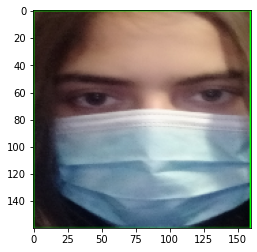

In [58]:
caras = extract_faces(imagen, cuadros_d)
plt.imshow(caras[0])

## Reconocimiento facial

In [59]:
# Leer el modelo de Reconocimiento Facial -> FaceNet
modelo_reconocimiento = load_model(direccion + 'modelo_reconocimiento_facial.h5')
print(modelo_reconocimiento.input_shape)
print(modelo_reconocimiento.output_shape)

(None, 160, 160, 3)
(None, 128)


In [60]:
def compute_embedding(modelo, cara):
  cara = cara.astype('float32')

  media, desviacion_est = cara.mean(), cara.std()
  cara = (cara - media) / desviacion_est

  cara = np.expand_dims(cara, axis = 0)

  embedding = modelo.predict(cara)
  return embedding

In [61]:
embedding = compute_embedding(modelo_reconocimiento, caras[0])
print(embedding)

[[ 1.18818545e+00  4.54199761e-01  7.77895987e-01  5.54504752e-01
  -2.09937954e+00 -3.52517456e-01  3.44295382e+00  1.30817667e-01
  -1.42119750e-01  4.30699438e-03  3.16797853e-01  6.82065710e-02
   1.86064208e+00  9.24851298e-01 -8.50683689e-01  1.45712841e+00
  -5.92840672e-01 -6.17677212e-01 -2.48035812e+00  4.29298162e-01
  -8.57045412e-01  1.08747387e+00  1.02419078e+00  6.99242711e-01
   7.13844448e-02 -1.23492074e+00  5.98857284e-01 -1.02276754e+00
   1.08271670e+00 -4.01603401e-01 -7.43327141e-01 -1.39597821e+00
   2.00660324e+00  1.16765153e+00  2.88182229e-01 -1.29865491e+00
  -5.29614925e-01  8.72463942e-01 -1.93172365e-01  4.85738993e-01
   1.00832045e-01  1.34720039e+00 -3.16979289e-01 -7.83720851e-01
   1.01290837e-01 -1.10628855e+00 -1.00061369e+00  7.70600080e-01
   1.15960181e+00  3.54160927e-02  6.72429681e-01  1.31261557e-01
  -4.51622814e-01 -1.82338834e+00  2.23176464e-01  1.82132399e+00
   4.69377875e-01  2.16460299e+00 -7.21174121e-01 -1.39056647e+00
  -1.29706

In [66]:
# Embeddings de referencia
embeddings_conocidos = []

print('Procesando caras conocidas...')
for nombre in os.listdir(dir_conocidos):
  if (nombre.endswith('.jpg') or nombre.endswith('.png') or nombre.endswith('.jpeg')) and nombre.startswith('Steph'): # <- Acá se pone el nombre de quién quieres buscar
    print(f'   {nombre}')                                                                                                 # (Natalia, Steph, Nander)
    imagen = load_image(dir_conocidos, nombre)
    cuadros_d = detect_faces(imagen)
    cara = extract_faces(imagen, cuadros_d)
    embeddings_conocidos.append(compute_embedding(modelo_reconocimiento, cara[0]))

Procesando caras conocidas...
   Steph08.jpeg
   Steph09.jpeg
   Steph10.jpeg
   Steph11.jpeg


In [67]:
print(embeddings_conocidos)

[array([[ 9.91504788e-02,  1.67458701e+00,  4.99426216e-01,
         8.28817368e-01, -2.11084157e-01,  2.06166983e+00,
         1.61689329e+00, -1.91594148e+00, -1.11311257e-01,
        -4.23973948e-01, -1.97050989e-01,  1.25015795e+00,
        -9.87086892e-01, -1.44597292e+00,  7.61054397e-01,
         1.32559764e+00,  2.09606361e+00,  5.35331145e-02,
        -6.42570317e-01,  7.50365332e-02, -1.06977493e-01,
        -9.27114844e-01,  9.97508690e-02, -3.86266351e-01,
        -1.89621007e+00, -1.69158709e+00, -1.07178342e+00,
        -5.40980935e-01, -1.00912726e+00, -4.09801066e-01,
         2.98804522e-01, -1.47062719e+00, -1.62239790e+00,
         9.66897249e-01,  1.74477947e+00, -1.43245840e+00,
        -7.34368637e-02,  1.35283545e-01,  9.21696663e-01,
         7.42029190e-01, -2.29336321e-02,  1.37307540e-01,
        -4.78014082e-01, -5.54094911e-02,  6.08182490e-01,
        -1.13836825e+00,  1.00801361e+00,  7.83789873e-01,
         3.05943847e-01,  7.31865168e-01,  1.53048068e-

In [68]:
def compare_faces(embs_ref, emb_desc, umbral = 11):
  distancias = []
  for emb_ref in embs_ref:
    distancias.append(np.linalg.norm(emb_ref - emb_desc))
  distancias = np.array(distancias)
  return distancias, list(distancias <= umbral)

In [69]:
# Reconocimiento de caras desconocidas

print('Procesando fotos desconocidas')
for nombre in os.listdir(dir_no_conocidos):
  if nombre.endswith('.jpg') or nombre.endswith('.png') or nombre.endswith('.jpeg'):
    print(f'     {nombre}')
    imagen = load_image(dir_no_conocidos, nombre)
    cuadros_d = detect_faces(imagen)
    caras = extract_faces(imagen, cuadros_d)

    # Por cada cara calcular embedding
    img_con_cuadros = imagen.copy()
    for cara, cuadro in zip(caras, cuadros_d):
      emb = compute_embedding(modelo_reconocimiento, cara)

      _, reconocimiento = compare_faces(embeddings_conocidos, emb)

      if any(reconocimiento):
        print('    encontrado!')
        img_con_cuadros = draw_box(img_con_cuadros, cuadro, (0, 255, 0))
      else:
        img_con_cuadros = draw_box(img_con_cuadros, cuadro, (255, 0, 0))

    cv2.imwrite(f'{dir_resultados}/{nombre}', cv2.cvtColor(img_con_cuadros, cv2.COLOR_RGB2BGR))
print('Acabó')

Procesando fotos desconocidas
     vengadores.png
     TonyStark5.jpg
     Steph.jpeg
    encontrado!
     Steph01.jpeg
    encontrado!
     Steph02.jpeg
    encontrado!
     Steph03.jpeg
    encontrado!
     Steph04.jpeg
    encontrado!
     Steph05.jpeg
    encontrado!
     Steph07.jpeg
    encontrado!
     Nander01.jpg
     Nander02.jpg
     Nander04.jpg
     Natalia02.jpg
     Natalia03.jpg
     Natalia04.jpg
Acabó
